In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_table('/mnt/c/Users/ouyangkang/Desktop/train_list.txt', sep='\t', header=None)
data.columns = ['Image_name', 'Label']

In [3]:
data.head()

,Image_name,Label
0,cat_12_train/8GOkTtqw7E6IHZx4olYnhzvXLCiRsUfM.jpg,0
1,cat_12_train/hwQDH3VBabeFXISfjlWEmYicoyr6qK1p.jpg,0
2,cat_12_train/RDgZKvM6sp3Tx9dlqiLNEVJjmcfQ0zI4.jpg,0
3,cat_12_train/ArBRzHyphTxFS2be9XLaU58m34PudlEf.jpg,0
4,cat_12_train/kmW7GTX6uyM2A53NBZxibYRpQnIVatCH.jpg,0


In [4]:
data.drop([122, 937, 944, 971, 985], axis=0, inplace=True)

In [5]:
image_path = '/mnt/c/Users/ouyangkang/Desktop/'

In [6]:
image_list = list(data.Image_name)
image_list[0]

'cat_12_train/8GOkTtqw7E6IHZx4olYnhzvXLCiRsUfM.jpg'

In [11]:
train = cv2.imread(image_path+image_list[0], 1)

In [7]:
import numpy as np
import torch


def prepare_data(data):
    # image_data
    image_path = '/mnt/c/Users/ouyangkang/Desktop/'
    image_list = list(data.Image_name)
    
    image_data = [torch.tensor(cv2.resize(cv2.imread(image_path+image_list[i]), (648, 648)), dtype=torch.float32) for i in range(len(image_list))]
    
    
    # label_data
    label_data = [int(i) for i in data.Label]
    labels = []
    for i in label_data:
        tmp = np.zeros((1,12))
        tmp[0, i] = 1
        tmp = torch.tensor(tmp, dtype=torch.float32)
        labels.append(tmp)
        
    return image_data, labels

In [8]:
image_data, label_data = prepare_data(data)

In [9]:
image_data[0].dtype

torch.float32

In [ ]:
# 122 937 944 971 985

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


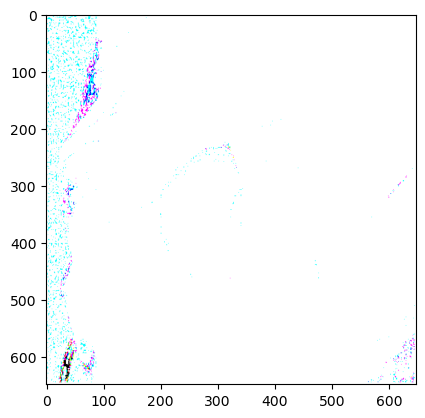

In [9]:
plt.figure()
plt.imshow(image_data[4]) # cv2 reading image with BRG channel, we ought to change it as RGB channel to avoid 色差
plt.show()

In [10]:
from torch.utils.data import RandomSampler, DataLoader

sampler = RandomSampler(image_data)
train_loader = DataLoader(list(zip(image_data, label_data)), batch_size=64, sampler=sampler)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cat_CNN(nn.Module):
    def __init__(self) -> None:
        super(Cat_CNN, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(246*162, 10)
        
    def forward(self, input):
        input = input.permute(0, 3, 1, 2)
        output = F.relu(self.bn1(self.conv_1(input)))
        output = F.relu(self.bn2(self.conv_2(output)))
        output = self.pool(output)
        output = F.relu(self.bn3(self.conv_3(output)))
        output = output.view(-1, 246*162)
        print(output.shape)
        
        output = self.fc(output)
        
        return output

In [12]:
model = Cat_CNN()
print(model)

Cat_CNN(
  (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=39852, out_features=10, bias=True)
)


In [13]:
from torch.optim import Adam

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [41]:
label_data[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
# from torch.autograd import Variable

def train(num_epochs):
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        
        for i, (image, label) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            
            output = model(image)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if i % 64 == 0:
                print('{}{} loss : {.3f}'.format(epoch+1, i+1, running_loss/64))

In [43]:
for image, label in train_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([64, 648, 648, 3])
torch.Size([64, 1, 12])


In [15]:
train(1)

: 

: 